In [1]:
import pandas as pd
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [2]:
# print(train.isnull().sum())
train.dropna(axis=0, how='any', inplace=True)
print(train.isnull().sum())

id                          0
MO HLADR+ MFI (cells/ul)    0
Neu CD64+MFI (cells/ul)     0
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    0
label                       0
dtype: int64


In [3]:
features = train[train.columns.drop(['id', 'label'])]
label = train['label']

In [4]:
# Detect the Outliers
from sklearn.ensemble import IsolationForest

isf = IsolationForest(n_jobs=-1, random_state=1)
isf.fit(features, label)

predict_result = isf.predict(features)
for i in range(len(predict_result)):
    if predict_result[i] == -1:
        features = features.drop(index=i, axis=0)
        label = label.drop(index=i)

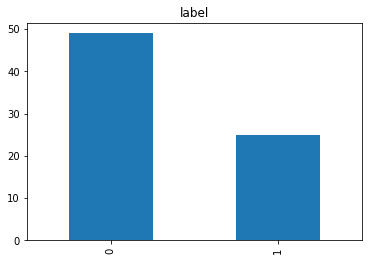

In [5]:
# Deal with Unbalanced Label
label.value_counts().plot(kind='bar', title='label')

# Use SMOTE to synthesize examples for minority class
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(features, label)

<AxesSubplot:title={'center':'label after resampling'}>

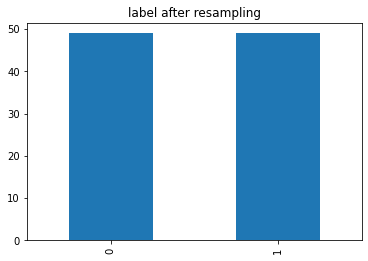

In [6]:
y_sm.value_counts().plot(kind='bar', title='label after resampling')

In [24]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

model = StackingClassifier(
    classifiers=[
        # DecisionTreeClassifier(max_depth=3),
        KNeighborsClassifier(n_neighbors=1),
        RandomForestClassifier(random_state=1),
        XGBClassifier(eval_metric=['logloss'], use_label_encoder=False),
        # LogisticRegression(max_iter=10000)
    ],
    meta_classifier=LogisticRegression(),
)

# params = {
#           'kneighborsclassifier__n_neighbors': range(1,6),
#           'randomforestclassifier__n_estimators': range(1,5),
#           'xgbclassifier__n_estimators': range(1,5),
#           'meta_classifier__C': [0.1, 1, 10]}

rfc = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': range(1, 50, 2),
    'max_depth': range(1, 50, 2),
    # 'min_samples_split': range(2, 10, 2),
    # 'max_features': range(1, 10, 2)
}

grid = GridSearchCV(estimator=rfc,
                    param_grid=params,
                    cv=3,
                    refit=True)

grid.fit(X_sm, y_sm)
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)
# model.fit(X_sm, y_sm)

Best parameters: {'max_depth': 3, 'n_estimators': 9}
Accuracy: 0.91


In [21]:
from sklearn.metrics import accuracy_score
# train_result = model.predict(features)
train_result = grid.predict(features)
print(accuracy_score(label, train_result))
test_result = grid.predict(test[test.columns.drop(['id'])])

0.918918918918919


In [19]:
pred = pd.DataFrame()
pred['label'] = test_result
pred.to_csv('submission.csv', index_label='id')